In [35]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from common.time_layers import *
from datasets import ptb
from simple_rnnlm import SimpleRnnlm


In [50]:
class RNN:
    def __init__(self,Wx,Wh,b):
        self.params=[Wx,Wh,b]
        self.grads=[np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        #역전파 시 중간값 저장용
        self.cache=None
        
    def forward(self,x,h_prev):
        Wx,Wh,b=self.params
        t=np.matmul(h_prev,Wh)+np.matmul(x,Wx)+b
        h_next=np.tanh(t)
        
        self.cache=(x,h_prev,h_next)
        return h_next
    
    def backward(self,dh_next):
        Wx,Wh,b=self.params
        x,h_prev,h_next=self.cache
        
        dt=dh_next*(1-h_next ** 2)
        db=np.sum(dt,axis=0)
        dWh=np.matmul(h_prev.T,dt)
        dh_prev=np.matmul(dt,Wh.T)
        dWx=np.matmul(x.T,dt)
        dx=np.matmul(dt,Wx.T)
        
        self.grads[0][...]=dWx
        self.grads[1][...]=dWh
        self.grads[2][...]=db
        
        return dx,dh_prev

In [51]:
class TimeRNN:
    def __init__(self,Wx,Wh,b,stateful=False):
        self.params=[Wx,Wh,b]
        self.grads=[np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.layers=None
        
        self.h,self.dh=None,None
        self.stateful=stateful
        
    def set_state(self,h):
        self.h=h
        
    def reset_state(self):
        self.h=None
    
    def forward(self,xs):
        Wx,Wh,b=self.params
        N,T,D=xs.shape
        D,H=Wx.shape
        
        self.layers=[]
        hs=np.empty((N,T,H),dtype='f')
        
        if not self.stateful or self.h is None:
            self.h=np.zeros((N,H),dtype='f')
            
        for t in range(T):
            layer=RNN(*self.params)
            self.h=layer.forward(xs[:,t,:],self.h)
            hs[:,t,:]=self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self,dhs):
        Wx,Wh,b=self.params
        N,T,H=dhs.shape
        D,H=Wx.shape
        
        dxs=np.empty((N,T,D),dtype='f')
        dh=0
        grads=[0,0,0]
        for t in reversed(range(T)):
            layer=self.layers[t]
            dx,dh=layer.backward(dhs[:,t,:]+dh)
            dxs[:,t,:]=dx
            
            for i, grad in enumerate(layer.grads):
                grads[i]+=grad
                
        for i,grad in enumerate(grads):
            self.grads[i][...]=grad
        self.dh=dh
        
        return dxs

In [52]:
class SimpleRnnlm:
    def __init__(self,vocab_size,wordvec_size,hidden_size):
        V,D,H=vocab_size,wordvec_size,hidden_size
        rn=np.random.randn
        
        embed_W=(rn(V,D)/100).astype('f')
        rnn_Wx=(rn(D,H)/np.sqrt(D)).astype('f')
        rnn_Wh=(rn(H,H)/np.sqrt(H)).astype('f')
        
        rnn_b=np.zeros(H).astype('f')
        affine_W=(rn(H,V)/np.sqrt(H)).astype('f')
        affine_b=np.zeros(V).astype('f')
        
        self.layers=[
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx,rnn_Wh,rnn_b,stateful=True),
            TimeAffine(affine_W,affine_b)
        ]
        self.loss_layer=TimeSoftmaxWithLoss()
        self.rnn_layer=self.layers[1]
        
        self.params,self.grads=[],[]
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def forward(self,xs,ts):
        for layer in self.layers:
            xs=layer.forward(xs)
        loss=self.loss_layer.forward(xs,ts)
        return loss
    
    def backward(self,dout=1):
        dout=self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout=layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

In [53]:
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

In [54]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

In [55]:
xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

말뭉치 크기: 1000, 어휘 수: 418


| 에폭 1 | 퍼플렉서티 366.11
| 에폭 2 | 퍼플렉서티 242.55
| 에폭 3 | 퍼플렉서티 216.32
| 에폭 4 | 퍼플렉서티 212.44
| 에폭 5 | 퍼플렉서티 204.07
| 에폭 6 | 퍼플렉서티 200.48
| 에폭 7 | 퍼플렉서티 197.47
| 에폭 8 | 퍼플렉서티 195.06
| 에폭 9 | 퍼플렉서티 190.28
| 에폭 10 | 퍼플렉서티 191.34
| 에폭 11 | 퍼플렉서티 187.68
| 에폭 12 | 퍼플렉서티 190.98
| 에폭 13 | 퍼플렉서티 188.32
| 에폭 14 | 퍼플렉서티 189.47
| 에폭 15 | 퍼플렉서티 188.66
| 에폭 16 | 퍼플렉서티 185.13
| 에폭 17 | 퍼플렉서티 182.33
| 에폭 18 | 퍼플렉서티 180.23
| 에폭 19 | 퍼플렉서티 179.81
| 에폭 20 | 퍼플렉서티 181.70
| 에폭 21 | 퍼플렉서티 178.22
| 에폭 22 | 퍼플렉서티 174.38
| 에폭 23 | 퍼플렉서티 172.80
| 에폭 24 | 퍼플렉서티 172.70
| 에폭 25 | 퍼플렉서티 170.28
| 에폭 26 | 퍼플렉서티 170.79
| 에폭 27 | 퍼플렉서티 164.80
| 에폭 28 | 퍼플렉서티 162.03
| 에폭 29 | 퍼플렉서티 157.45
| 에폭 30 | 퍼플렉서티 153.07
| 에폭 31 | 퍼플렉서티 154.22
| 에폭 32 | 퍼플렉서티 147.37
| 에폭 33 | 퍼플렉서티 145.88
| 에폭 34 | 퍼플렉서티 139.16
| 에폭 35 | 퍼플렉서티 139.00
| 에폭 36 | 퍼플렉서티 132.22
| 에폭 37 | 퍼플렉서티 126.05
| 에폭 38 | 퍼플렉서티 121.76
| 에폭 39 | 퍼플렉서티 117.29
| 에폭 40 | 퍼플렉서티 113.60
| 에폭 41 | 퍼플렉서티 111.53
| 에폭 42 | 퍼플렉서티 104.86
| 에폭 43 | 퍼플렉서티 100.65
| 에폭 44 | 퍼플렉서티 97.2

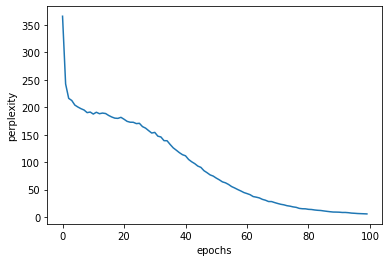

In [56]:
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()